In [ ]:
!pip install shap

In [37]:
import pandas as pd
import numpy as np
import duckdb
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt

db = duckdb.connect('imdb.duckdb')

## Feature Engineering

We have the following tables to use:
- movies
- directors
- writers
- talents
- companies

I would like to incorprate the information in these tables into the movies table as added features

In [3]:
db.execute("""     
    CREATE OR REPLACE TABLE movies3 AS
        WITH ranked_directors AS (
            SELECT 
                a.tconst, 
                b.directorid, 
                b.primaryName, 
                b.ratings_avg, 
                b.ratings_count, 
                b.avg_revenue, 
                b.total_revenue,
                b.num_titles,
                ROW_NUMBER() OVER (PARTITION BY a.tconst ORDER BY b.total_revenue DESC) AS rownum
            FROM title_directors a 
            LEFT JOIN directors b 
            ON a.directorid = b.directorid
        )
        SELECT 
            c.*,
            ratings_avg as director_ratings_avg, 
            ratings_count as director_ratings_count, 
            avg_revenue as director_avg_revenue, 
            total_revenue as director_total_revenue,
            num_titles as director_num_titles
        FROM movies c
        LEFT JOIN
           ranked_directors d
        ON c.tconst = d.tconst
        WHERE rownum = 1;
""")

In [4]:
db.execute("""     
    CREATE OR REPLACE TABLE movies4 AS
        WITH ranked_writers AS (
            SELECT 
                a.tconst, 
                b.writerid, 
                b.primaryName, 
                b.ratings_avg, 
                b.ratings_count, 
                b.avg_revenue, 
                b.total_revenue,
                b.num_titles,
                ROW_NUMBER() OVER (PARTITION BY a.tconst ORDER BY b.total_revenue DESC) AS rownum
            FROM title_writers a 
            LEFT JOIN writers b 
            ON a.writerid = b.writerid
        )
        SELECT 
            c.*,
            ratings_avg as writer_ratings_avg, 
            ratings_count as writer_ratings_count, 
            avg_revenue as writer_avg_revenue, 
            total_revenue as writer_total_revenue,
            num_titles as writer_num_titles
        FROM movies3 c
        LEFT JOIN
           ranked_writers d
        ON c.tconst = d.tconst
        WHERE rownum = 1;
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [5]:
db.execute("""     
    CREATE OR REPLACE TABLE movies5 AS
        WITH ranked_talents AS (
            SELECT 
                a.tconst, 
                b.talentid, 
                b.primaryName, 
                b.ratings_avg, 
                b.ratings_count, 
                b.avg_revenue, 
                b.total_revenue,
                b.num_titles,
                ROW_NUMBER() OVER (PARTITION BY a.tconst ORDER BY b.total_revenue DESC) AS rownum
            FROM title_principals_raw a 
            LEFT JOIN talents b 
            ON a.nconst = b.talentid
        )
        SELECT 
            c.*,
            ratings_avg as actor1_ratings_avg, 
            ratings_count as actor1_ratings_count, 
            avg_revenue as actor1_avg_revenue, 
            total_revenue as actor1_total_revenue,
            num_titles as actor1_num_titles
        FROM movies4 c
        LEFT JOIN
           ranked_talents d
        ON c.tconst = d.tconst
        WHERE rownum = 1;
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [6]:
db.execute("""     
    CREATE OR REPLACE TABLE movies6 AS
        WITH ranked_talents AS (
            SELECT 
                a.tconst, 
                b.talentid, 
                b.primaryName, 
                b.ratings_avg, 
                b.ratings_count, 
                b.avg_revenue, 
                b.total_revenue,
                b.num_titles,
                ROW_NUMBER() OVER (PARTITION BY a.tconst ORDER BY b.total_revenue DESC) AS rownum
            FROM title_principals_raw a 
            LEFT JOIN talents b 
            ON a.nconst = b.talentid
        )
        SELECT 
            c.*,
            ratings_avg as actor2_ratings_avg, 
            ratings_count as actor2_ratings_count, 
            avg_revenue as actor2_avg_revenue, 
            total_revenue as actor2_total_revenue,
            num_titles as actor2_num_titles
        FROM movies5 c
        LEFT JOIN
           ranked_talents d
        ON c.tconst = d.tconst
        WHERE rownum = 2;
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [7]:
db.execute("""     
    CREATE OR REPLACE TABLE movies7 AS
        SELECT 
            a.*,
            actors_ratings_avg, 
            actors_ratings_count, 
            actors_avg_revenue,
            actors_total_revenue
        FROM movies6 a
        LEFT JOIN
            (SELECT b.tconst,
                avg(ratings_avg) as actors_ratings_avg, 
                avg(ratings_count) as actors_ratings_count, 
                avg(avg_revenue) as actors_avg_revenue,
                sum(total_revenue) as actors_total_revenue
            FROM
            title_principals_raw b
            LEFT JOIN
            talents c
            ON b.nconst = c.talentid
            GROUP BY b.tconst
            ) d
        ON a.tconst = d.tconst
""")

In [45]:
db.execute("""     
    CREATE OR REPLACE TABLE movies8 AS
        WITH ranked_companies AS (
            SELECT 
                a.imdb_id, 
                b.companyid, 
                b.company, 
                b.ratings_avg, 
                b.ratings_count, 
                b.avg_revenue, 
                b.total_revenue,
                b.num_titles,
                ROW_NUMBER() OVER (PARTITION BY a.imdb_id ORDER BY b.total_revenue DESC) AS rownum
            FROM title_companies a 
            LEFT JOIN companies b 
            ON a.companyid = b.companyid
        )
        SELECT 
            c.*,
            ratings_avg as company_ratings_avg, 
            ratings_count as company_ratings_count, 
            avg_revenue as company_avg_revenue, 
            total_revenue as company_total_revenue,
            num_titles as company_num_titles
        FROM movies7 c
        LEFT JOIN
           ranked_companies d
        ON c.tconst = d.imdb_id
        WHERE rownum = 1;
""")

We are done with the feature engineering. We can now export to dataframe for training.

For now, we choose to extract only the movies where revenue is not null. Since the goal is to predict AAA movies, it is the revenue which is paramount and not ratings. However it is also a valid case study to focus on the ratings

## Training and Evaluating the XGBoost model

In [46]:
db.execute(""" 
select count(*) from movies8 where revenue >0
""").fetchdf()    # 15461

,count_star()
0,14604


In [48]:
data = db.execute(""" 
    select tconst, revenue, 
            isAdult, year, runtime, genres, budget,
            dayofyear, weeknum, original_language, --production_companies, 
            director_ratings_avg, director_ratings_count, director_avg_revenue, director_total_revenue, director_num_titles,
            writer_ratings_avg, writer_ratings_count, writer_avg_revenue, writer_total_revenue, writer_num_titles,
            actor1_ratings_avg, actor1_ratings_count, actor1_avg_revenue, actor1_total_revenue, actor1_num_titles,
            actor2_ratings_avg, actor2_ratings_count, actor2_avg_revenue, actor2_total_revenue, actor2_num_titles,
            actors_ratings_avg, actors_ratings_count, actors_avg_revenue, actors_total_revenue,
            company_ratings_avg, company_ratings_count, company_avg_revenue, company_total_revenue, company_num_titles
    from movies8 where revenue >0
""").fetchdf()

In [49]:
data_exploded = data.explode('genres')
data_one_hot = pd.get_dummies(data_exploded, columns=['genres', 'original_language'])
data_one_hot = data_one_hot.groupby('tconst').max().reset_index()

In [50]:
X = data_one_hot.drop(columns=['tconst', 'revenue'])
y = data_one_hot['revenue']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'reg:squarederror',
    'max_depth': 8,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

In [52]:
bst = xgb.train(params, dtrain, num_boost_round=100)

In [53]:
y_pred = bst.predict(dtest)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"The MAPE is: {mape}")
print(f"The R squared is: {r2}")

The MAPE is: 4738.884415053664
The R squared is: 0.8932213187217712


<Figure size 2000x1500 with 0 Axes>

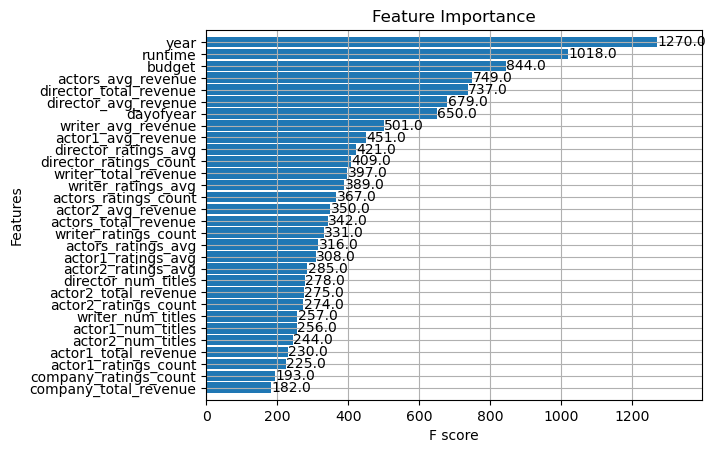

In [54]:
plt.figure(figsize=(20, 15))
xgb.plot_importance(bst, max_num_features=30, height=0.9)
plt.title('Feature Importance')
plt.show()

<Figure size 2000x1500 with 0 Axes>

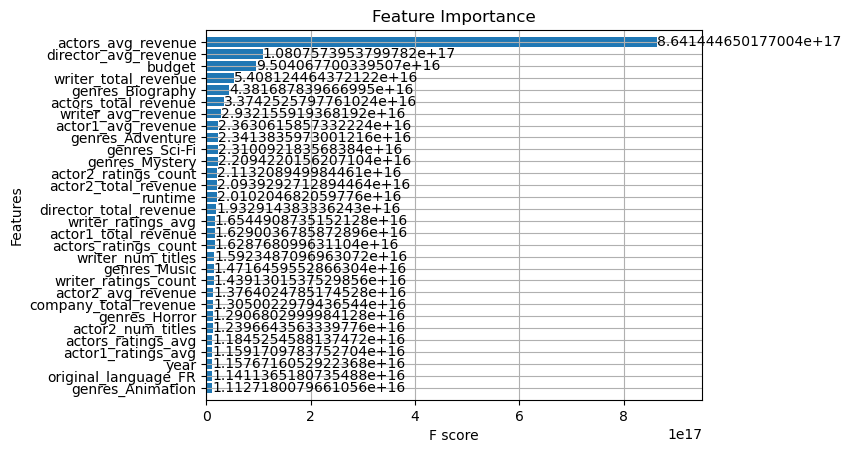

In [55]:
plt.figure(figsize=(20, 15))
xgb.plot_importance(bst, importance_type='gain', max_num_features=30, height=0.8)
plt.title('Feature Importance')
plt.show()

In [56]:
def analyze_feature_relationships(model, X_train, dtrain, feature_names=None):
    # Get SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    
    # Summary plot shows feature importance and direction
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_train, feature_names=feature_names)
    
    # Get feature correlations with predictions
    predictions = model.predict(dtrain)
    correlations = {}
    for i, col in enumerate(X_train.columns):
        corr = np.corrcoef(X_train[col], predictions)[0,1]
        correlations[col] = corr
    
    # Print correlation directions
    print("\nFeature correlations with predictions:")
    for feat, corr in sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True):
        direction = "positive" if corr > 0 else "negative"
        print(f"{feat}: {direction} correlation ({corr:.3f})")
    
    return shap_values, correlations

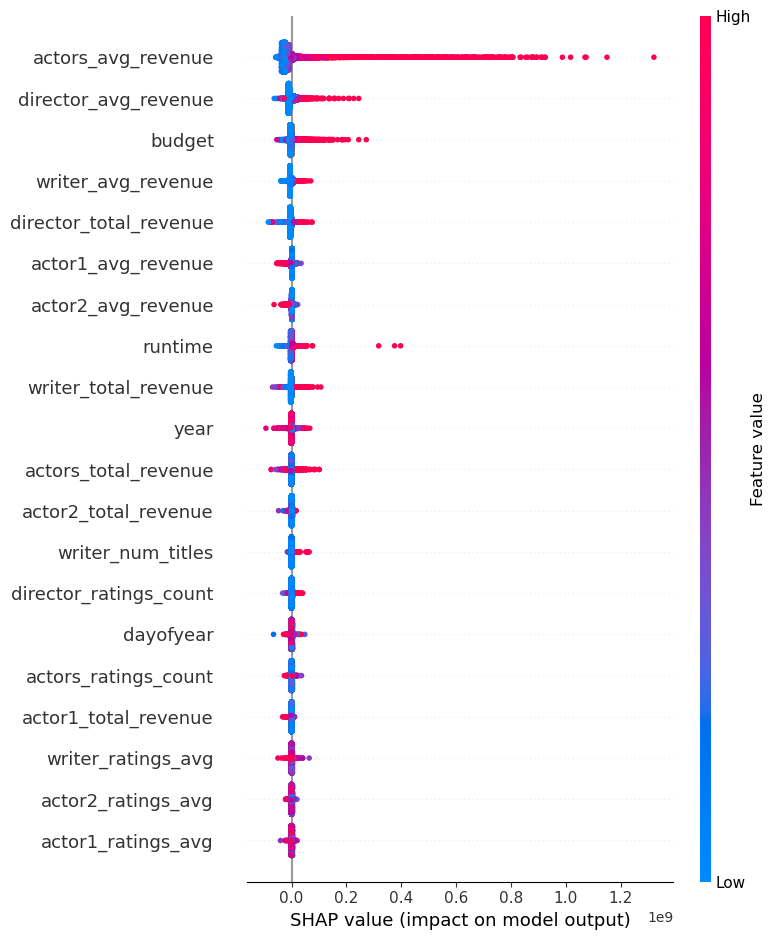


Feature correlations with predictions:
year: negative correlation (nan)
runtime: positive correlation (0.195)
budget: negative correlation (nan)
dayofyear: negative correlation (nan)
weeknum: negative correlation (nan)
director_ratings_avg: negative correlation (nan)
director_ratings_count: negative correlation (nan)
director_avg_revenue: positive correlation (0.739)
writer_ratings_avg: negative correlation (nan)
writer_ratings_count: negative correlation (nan)
writer_avg_revenue: positive correlation (0.688)
writer_total_revenue: positive correlation (0.609)
director_total_revenue: positive correlation (0.566)
writer_num_titles: positive correlation (0.231)
original_language_EN: positive correlation (0.184)
genres_Sci-Fi: positive correlation (0.145)
genres_Drama: negative correlation (-0.130)
genres_Animation: positive correlation (0.118)
genres_Fantasy: positive correlation (0.091)
original_language_ES: negative correlation (-0.068)
original_language_FR: negative correlation (-0.05

/home/lean/anaconda3/envs/ml/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/lean/anaconda3/envs/ml/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [32]:
shap_values, correlations = analyze_feature_relationships(bst, X_train, dtrain, feature_names=X_train.columns)

In [57]:
db.close()